In [1]:
!pip install lazypredict

## **Import Needed Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lazypredict.Supervised import LazyClassifier

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## **EDA**

In [3]:
df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


In [6]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

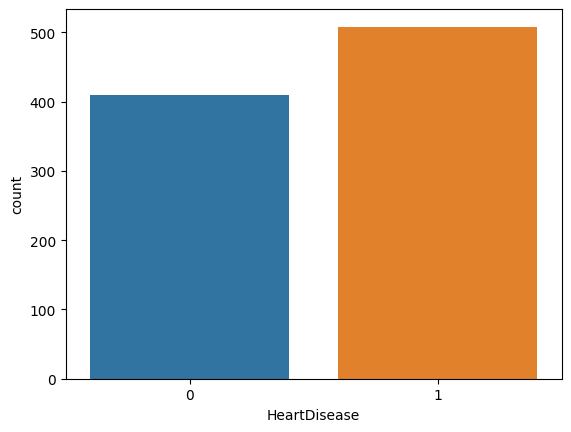

In [7]:
sns.countplot(x = "HeartDisease", data = df);

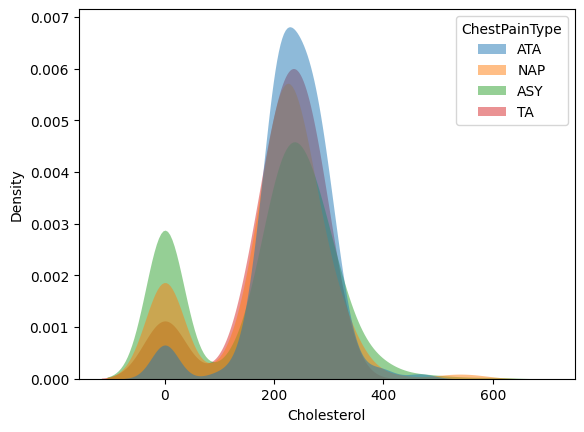

In [8]:
sns.kdeplot( data=df, x="Cholesterol", hue="ChestPainType", fill=True, common_norm=False, palette="tab10", alpha=.5, linewidth=0);

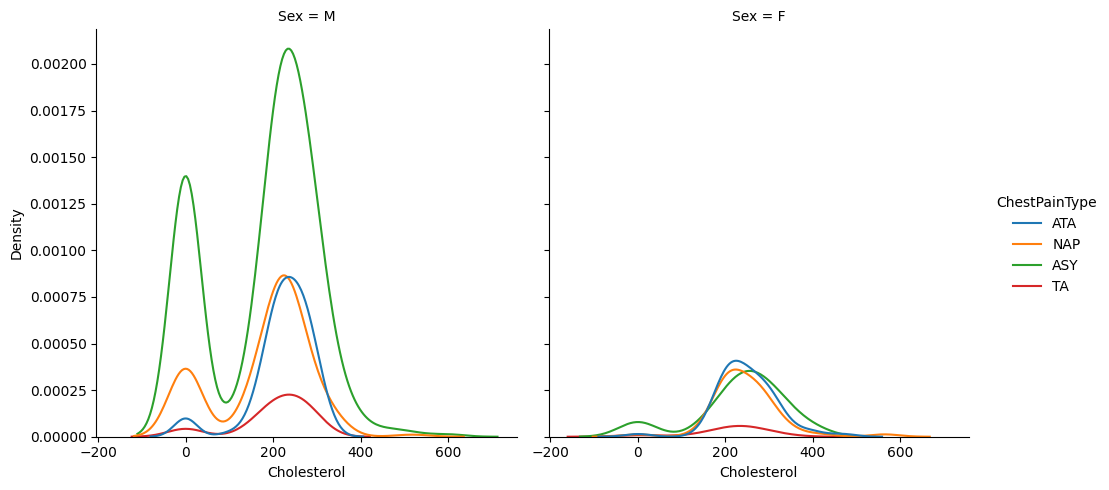

In [9]:
sns.displot(data=df, x="Cholesterol", hue="ChestPainType", col="Sex", kind="kde");

## **Preprocessing**

### **Define features X and target y**

In [10]:
X = df.drop('HeartDisease' , axis='columns')
y = df['HeartDisease']

In [11]:
X

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up
...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.20,Flat
914,68,M,ASY,144,193,1,Normal,141,N,3.40,Flat
915,57,M,ASY,130,131,0,Normal,115,Y,1.20,Flat
916,57,F,ATA,130,236,0,LVH,174,N,0.00,Flat


In [12]:
y

0      0
1      1
2      0
3      1
4      0
      ..
913    1
914    1
915    1
916    1
917    0
Name: HeartDisease, Length: 918, dtype: int64

### **Encode string columns**

In [13]:
X['ChestPainType'].value_counts()

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

In [14]:
X = X.apply(LabelEncoder().fit_transform)

In [15]:
X

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,12,1,1,41,147,0,1,98,0,10,2
1,21,0,2,55,40,0,1,82,0,20,1
2,9,1,1,31,141,0,2,25,0,10,2
3,20,0,0,39,72,0,1,34,1,25,1
4,26,1,2,49,53,0,1,48,0,10,2
...,...,...,...,...,...,...,...,...,...,...,...
913,17,1,3,14,122,0,1,58,0,22,1
914,40,1,0,45,51,1,1,67,0,42,1
915,29,1,0,31,9,0,1,41,1,22,1
916,29,0,1,31,94,0,0,100,0,10,1


### **Data Scaling**

In [16]:
standardScalerModel = StandardScaler()
X = standardScalerModel.fit_transform(X)

### **Data Splitting**

In [17]:
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2 , random_state=42 , shuffle=True)

## **XGBoost Model**

In [18]:
XG_model = XGBClassifier(n_estimators = 1000 ,learning_rate=0.001 )
XG_model.fit(X_train , y_train ,verbose=False, early_stopping_rounds=5 , eval_set=[(X_test , y_test)])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [19]:
XG_model.score(X_train , y_train)

0.9196185286103542

In [20]:
XG_model.score(X_test , y_test)

0.875

## **Voting Classifier Model**

In [21]:
estimator = []
estimator.append(('LR' , LogisticRegression()))
estimator.append(('SVC' , SVC(gamma = 'auto' , C=5)))
estimator.append(('DTC' , DecisionTreeClassifier()))

VOT_model = VotingClassifier(estimators= estimator , voting='hard')
VOT_model.fit(X_train , y_train)

VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('SVC', SVC(C=5, gamma='auto')),
                             ('DTC', DecisionTreeClassifier())])

In [22]:
VOT_model.score(X_train , y_train)

0.94141689373297

In [23]:
VOT_model.score(X_test , y_test)

0.8641304347826086

## **Lazy Classifier Model**

In [24]:
clf = LazyClassifier(verbose=1)
models , predictions = clf.fit(X_train , X_test , y_train , y_test)

 14%|█▍        | 4/29 [00:00<00:01, 13.83it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.8532608695652174, 'Balanced Accuracy': 0.8574462920257313, 'ROC AUC': 0.8574462920257312, 'F1 Score': 0.8540908469900917, 'Time taken': 0.13939595222473145}
{'Model': 'BaggingClassifier', 'Accuracy': 0.8641304347826086, 'Balanced Accuracy': 0.8704333050127442, 'ROC AUC': 0.8704333050127443, 'F1 Score': 0.8649782251731277, 'Time taken': 0.04958486557006836}
{'Model': 'BernoulliNB', 'Accuracy': 0.8097826086956522, 'Balanced Accuracy': 0.8164218958611482, 'ROC AUC': 0.8164218958611482, 'F1 Score': 0.8110349709406625, 'Time taken': 0.01333475112915039}
{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.8315217391304348, 'Balanced Accuracy': 0.8369340939434398, 'ROC AUC': 0.8369340939434396, 'F1 Score': 0.8325729992146783, 'Time taken': 0.10552096366882324}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.7934782608695652, 'Balanced Accuracy': 0.7987619856778736, 'ROC AUC': 0.7987619856778736, 'F1 Score': 0.7948085929598723, 'Time taken': 0.0140

 45%|████▍     | 13/29 [00:00<00:00, 19.76it/s]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.8913043478260869, 'Balanced Accuracy': 0.8919771816968078, 'ROC AUC': 0.8919771816968078, 'F1 Score': 0.8916450454700316, 'Time taken': 0.19755983352661133}
{'Model': 'GaussianNB', 'Accuracy': 0.8097826086956522, 'Balanced Accuracy': 0.8164218958611482, 'ROC AUC': 0.8164218958611482, 'F1 Score': 0.8110349709406625, 'Time taken': 0.012499332427978516}
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.8641304347826086, 'Balanced Accuracy': 0.8667920864182546, 'ROC AUC': 0.8667920864182546, 'F1 Score': 0.8647868094938039, 'Time taken': 0.024851560592651367}
{'Model': 'LabelPropagation', 'Accuracy': 0.842391304347826, 'Balanced Accuracy': 0.8499211069304526, 'ROC AUC': 0.8499211069304526, 'F1 Score': 0.8434289759222632, 'Time taken': 0.047899484634399414}
{'Model': 'LabelSpreading', 'Accuracy': 0.842391304347826, 'Balanced Accuracy': 0.8499211069304526, 'ROC AUC': 0.8499211069304526, 'F1 Score': 0.8434289759222632, 'Time taken': 0.0821845531463

 69%|██████▉   | 20/29 [00:00<00:00, 26.56it/s]

{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.8260869565217391, 'Balanced Accuracy': 0.832261196747178, 'ROC AUC': 0.832261196747178, 'F1 Score': 0.8272072361767344, 'Time taken': 0.03638958930969238}
{'Model': 'LinearSVC', 'Accuracy': 0.8260869565217391, 'Balanced Accuracy': 0.8340818060444228, 'ROC AUC': 0.8340818060444228, 'F1 Score': 0.8272463768115942, 'Time taken': 0.07140588760375977}
{'Model': 'LogisticRegression', 'Accuracy': 0.8369565217391305, 'Balanced Accuracy': 0.8434276004369462, 'ROC AUC': 0.8434276004369461, 'F1 Score': 0.8380067839156886, 'Time taken': 0.01910853385925293}
{'Model': 'NearestCentroid', 'Accuracy': 0.8097826086956522, 'Balanced Accuracy': 0.8218837237528827, 'ROC AUC': 0.8218837237528825, 'F1 Score': 0.8109610712651678, 'Time taken': 0.019010066986083984}
{'Model': 'NuSVC', 'Accuracy': 0.8586956521739131, 'Balanced Accuracy': 0.8548367520330138, 'ROC AUC': 0.8548367520330137, 'F1 Score': 0.8586956521739131, 'Time taken': 0.03540182113647461}
{'M

 97%|█████████▋| 28/29 [00:01<00:00, 22.91it/s]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.8804347826086957, 'Balanced Accuracy': 0.87716955941255, 'ROC AUC': 0.8771695594125501, 'F1 Score': 0.8804347826086957, 'Time taken': 0.2745499610900879}
{'Model': 'RidgeClassifier', 'Accuracy': 0.8260869565217391, 'Balanced Accuracy': 0.832261196747178, 'ROC AUC': 0.832261196747178, 'F1 Score': 0.8272072361767344, 'Time taken': 0.020773649215698242}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.8260869565217391, 'Balanced Accuracy': 0.832261196747178, 'ROC AUC': 0.832261196747178, 'F1 Score': 0.8272072361767344, 'Time taken': 0.015076398849487305}
{'Model': 'SGDClassifier', 'Accuracy': 0.8097826086956522, 'Balanced Accuracy': 0.8218837237528827, 'ROC AUC': 0.8218837237528825, 'F1 Score': 0.8109610712651678, 'Time taken': 0.014495849609375}
{'Model': 'SVC', 'Accuracy': 0.8586956521739131, 'Balanced Accuracy': 0.8584779706275033, 'ROC AUC': 0.8584779706275034, 'F1 Score': 0.8591385591110412, 'Time taken': 0.025335073471069336}
{'Model': '

100%|██████████| 29/29 [00:01<00:00, 19.56it/s]

{'Model': 'LGBMClassifier', 'Accuracy': 0.8369565217391305, 'Balanced Accuracy': 0.8434276004369462, 'ROC AUC': 0.8434276004369461, 'F1 Score': 0.8380067839156886, 'Time taken': 0.10529232025146484}


In [25]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.89               0.89     0.89      0.89   
RandomForestClassifier             0.88               0.88     0.88      0.88   
XGBClassifier                      0.87               0.87     0.87      0.87   
BaggingClassifier                  0.86               0.87     0.87      0.86   
KNeighborsClassifier               0.86               0.87     0.87      0.86   
SVC                                0.86               0.86     0.86      0.86   
AdaBoostClassifier                 0.85               0.86     0.86      0.85   
NuSVC                              0.86               0.85     0.85      0.86   
LabelSpreading                     0.84               0.85     0.85      0.84   
LabelPropagation                   0.84               0.85     0.85      0.84   
LogisticRegression          

## **Conclusion**

* Best accuracy is 89% 
* I used various types of models ana automated models 
* Great dataset i enjoyed working in it